## Fundamental Matrix Estimation From Point Correspondences


In [1]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import scipy.io as sio
from epipolar_utils import *



### (a) Implement the linear least-squares eight point algorithm in lls_eight_point_alg()

In [52]:
'''
LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using 
linear least squares eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the linear least squares eight
point algorithm works
'''
def lls_eight_point_alg(points1, points2):
    def get_w_raw(point1, point2):
        return np.array([
            point1[0] * point2[0],
            point1[0] * point2[1],
            point1[0],
            point1[1] * point2[0],
            point1[1] * point2[1],
            point1[1],
            point2[0],
            point2[1],
            1
        ])
    
    W = np.zeros((points1.shape[0], 9))
    
    for idx in range(0, points1.shape[0]):
        W[idx, :] = get_w_raw(points1[idx], points2[idx])

    #print ("W\n", W)
    
    U, s, V = np.linalg.svd(W)
    #print ("U\n", U)
    #print ("s\n", s)
    #print ("V\n", V[8, :])
    
    F_cap = np.reshape(V[8, :], (3, 3))
    #print ("F_cap\n", F_cap)
    
    U, s, V = np.linalg.svd(F_cap)
    
    s_rank2 = np.zeros((s.shape[0], s.shape[0]))
    s_rank2[0, 0] = s[0]
    s_rank2[1, 1] = s[1]
    F = np.dot(U, np.dot(s_rank2, V))
    
    return F

### (b) Implement the normalized eight point algorithm in normalized_eight_point_alg()

In [53]:
'''
NORMALIZED_EIGHT_POINT_ALG  computes the fundamental matrix from matching points
using the normalized eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the normalized eight
point algorithm works
'''
def normalized_eight_point_alg(points1, points2):
    
    def get_normalization_matrix(points):
        mean = np.mean(points, axis = 0)
        #print (mean)
        dist = points - mean
        #print ("Dist\n", dist)
        #print ("Dist.shape\n", dist.shape)
        #print ("Total dist\n", np.sqrt(np.diag(np.dot(dist, dist.T))))
        mean_dist = np.mean(np.sqrt(np.diag(np.dot(dist, dist.T))))
        #print ("Mean_dist\n", mean_dist)
        #print ("Mean_dist.shape\n", mean_dist.shape)
        T = np.zeros((3, 3))
        T[0][0] = (np.sqrt(2) / mean_dist)
        T[0][2] = -1 * mean[0] * (np.sqrt(2) / mean_dist)
        T[1][1] = (np.sqrt(2) / mean_dist)
        T[1][2] = -1 * mean[1] * (np.sqrt(2) / mean_dist)
        T[2, :] = [0, 0, 1]
        return T

    
    T1 = get_normalization_matrix(points1)
    T2 = get_normalization_matrix(points2)
    #print (T1)
    #print (T2)
    
    points1_norm = np.dot(T1, points1.T).T
    points2_norm = np.dot(T2, points2.T).T    
    #print ("Points1.norm\n", points1_norm)
    #print ("Points2.norm\n", points2_norm)

    F_norm = lls_eight_point_alg(points1_norm, points2_norm)    
    F = np.dot(np.dot(T1.T, F_norm), T2)
    #F = T1.T * F_norm * T2
    return F



------------------------------------
Set:data/set1
------------------------------------
('Fundamental Matrix from LLS  8-point algorithm:\n', array([[  1.55218081e-06,  -5.86997052e-06,  -3.52312036e-03],
       [ -8.18161523e-06,  -3.02892219e-07,   1.41453881e-02],
       [ -1.50440111e-03,  -1.13607605e-02,   9.99828068e-01]]))
("p'^T F p =", 0.095229612040613393)
('Fundamental Matrix from normalized 8-point algorithm:\n', array([[  7.69564303e-07,  -0.00000000e+00,   0.00000000e+00],
       [ -0.00000000e+00,  -4.01132413e-07,  -0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   2.53764810e-02]]))
------------------------------------
Set:data/set2
------------------------------------
('Fundamental Matrix from LLS  8-point algorithm:\n', array([[ -5.63087200e-06,  -2.77622828e-05,   1.07623595e-02],
       [  2.74976583e-05,  -6.74748522e-06,  -1.22519240e-02],
       [ -6.42650411e-03,   1.52182033e-02,  -9.99730547e-01]]))
("p'^T F p =", 0.033955871083676439)
('Fundame

### (c) Fill out the method plot_epipolar_lines_on_images()

------------------------------------
Set:data/set1
------------------------------------
('Fundamental Matrix from LLS  8-point algorithm:\n', array([[  1.55218081e-06,  -5.86997052e-06,  -3.52312036e-03],
       [ -8.18161523e-06,  -3.02892219e-07,   1.41453881e-02],
       [ -1.50440111e-03,  -1.13607605e-02,   9.99828068e-01]]))
("p'^T F p =", 0.095229612040613393)
('Fundamental Matrix from normalized 8-point algorithm:\n', array([[  7.69564303e-07,  -0.00000000e+00,   0.00000000e+00],
       [ -0.00000000e+00,  -4.01132413e-07,  -0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   2.53764810e-02]]))


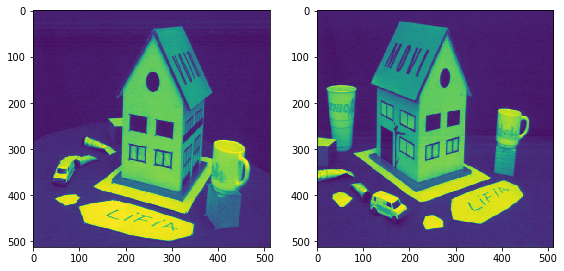

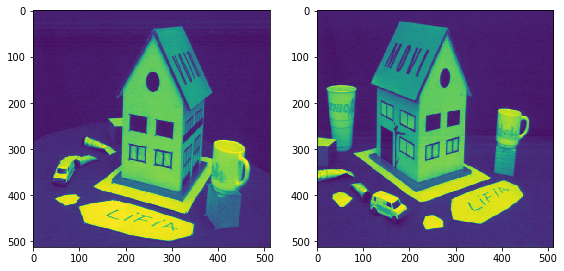

------------------------------------
Set:data/set2
------------------------------------
('Fundamental Matrix from LLS  8-point algorithm:\n', array([[ -5.63087200e-06,  -2.77622828e-05,   1.07623595e-02],
       [  2.74976583e-05,  -6.74748522e-06,  -1.22519240e-02],
       [ -6.42650411e-03,   1.52182033e-02,  -9.99730547e-01]]))
("p'^T F p =", 0.033955871083676439)
('Fundamental Matrix from normalized 8-point algorithm:\n', array([[ -1.76258641e-07,   0.00000000e+00,  -0.00000000e+00],
       [  0.00000000e+00,   3.75025436e-07,   0.00000000e+00],
       [ -0.00000000e+00,  -0.00000000e+00,  -1.92996435e-02]]))


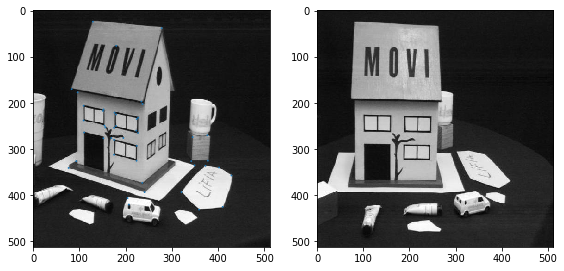

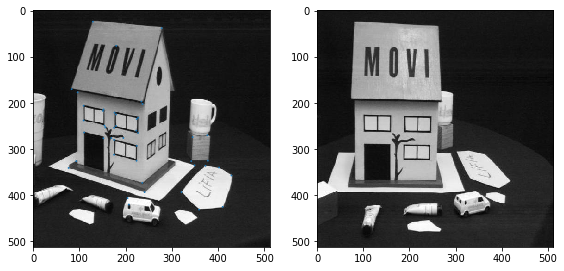

In [60]:
from matplotlib.patches import Circle

'''
PLOT_EPIPOLAR_LINES_ON_IMAGES given a pair of images and corresponding points,
draws the epipolar lines on the images
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    im1 - a HxW(xC) matrix that contains pixel values from the first image 
    im2 - a HxW(xC) matrix that contains pixel values from the second image 
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    Nothing; instead, plots the two images with the matching points and
    their corresponding epipolar lines. See Figure 1 within the problem set
    handout for an example
'''
def plot_epipolar_lines_on_images(points1, points2, im1, im2, F):
    fig = plt.figure(figsize = (50, 20))
    image1 = fig.add_subplot(1, 10, 1)
    for point in points1:
        circ = Circle((point[0], point[1]),2)
        image1.add_patch(circ)
    image1.imshow(im1)
    
    image2 = fig.add_subplot(1, 10, 2)
    image2.imshow(im2)
    plt.show()


for im_set in ['data/set1', 'data/set2']:
    print ('------------------------------------')
    print ('Set:%s' % im_set)
    print ('------------------------------------')

    # Read in the data
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)

    # Running the linear least squares eight point algorithm
    F_lls = lls_eight_point_alg(points1, points2)
    print ("Fundamental Matrix from LLS  8-point algorithm:\n", F_lls)
    #print ("Distance to lines in image 1 for LLS:", \
    #    compute_distance_to_epipolar_lines(points1, points2, F_lls))
    #print ("Distance to lines in image 2 for LLS:", \
    #    compute_distance_to_epipolar_lines(points2, points1, F_lls.T))

    # Running the normalized eight point algorithm
    F_normalized = normalized_eight_point_alg(points1, points2)

    pFp = [points2[i].dot(F_normalized.dot(points1[i])) 
        for i in xrange(points1.shape[0])]
    print ("p'^T F p =", np.abs(pFp).max())
    print ("Fundamental Matrix from normalized 8-point algorithm:\n", \
        F_normalized)
    #print ("Distance to lines in image 1 for normalized:", \
    #    compute_distance_to_epipolar_lines(points1, points2, F_normalized))
    #print ("Distance to lines in image 2 for normalized:", \
    #    compute_distance_to_epipolar_lines(points2, points1, F_normalized.T))

    # Plotting the epipolar lines
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_normalized)

    plt.show()

### (d) Determine epipolar lines

In [66]:
'''
LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using 
linear least squares eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the linear least squares eight
point algorithm works
'''
def lls_eight_point_alg(points1, points2):    
    def get_w_row_from_two_points(point1, point2):
        return np.array([
            point1[0]*point2[0],
            point1[0]*point2[1],
            point1[0],
            point1[1]*point2[0],
            point1[1]*point2[1],
            point1[1],
            point2[0],
            point2[1],
            1
        ])

    W = np.zeros((points1.shape[0], 9))
    
    for idx in range(0, points1.shape[0]):
        W[idx, :] = get_w_row_from_two_points(points1[idx], points2[idx])
    
    # print ("W\n", W)
    
    U, s, V  = np.linalg.svd(W)
    
    #print (V.shape)
    print ("U:\n", U)
    print ("s:\n", s)
    print ("V:\n", V)
    
    # The last row of V is the solution of W*f=0 under the constraint of ||f|| = 1
    #print (V[8, :])
    F_cap = np.reshape(V[8, :], (3,3))
    #print ("F_cap\n", F_cap)
    
    # Now enforce rank-2:
    U, s, V = np.linalg.svd(F_cap)
    F = np.zeros_like(F_cap)
    for i in range(0, 2):
        F =  F + s[i] * np.outer(U[:,i], V[i, :])
    
    return F


In [6]:
'''
COMPUTE_DISTANCE_TO_EPIPOLAR_LINES  computes the average distance of a set a 
points to their corresponding epipolar lines
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    average_distance - the average distance of each point to the epipolar line
'''
def compute_distance_to_epipolar_lines(points1, points2, F):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')



In [7]:

for im_set in ['data/set1', 'data/set2']:
    print ('------------------------------------')
    print ('Set:%s' % im_set)
    print ('------------------------------------')

    # Read in the data
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)

    # Running the linear least squares eight point algorithm
    F_lls = lls_eight_point_alg(points1, points2)
    print ("Fundamental Matrix from LLS  8-point algorithm:\n", F_lls)
    print ("Distance to lines in image 1 for LLS:", \
        compute_distance_to_epipolar_lines(points1, points2, F_lls))
    print ("Distance to lines in image 2 for LLS:", \
        compute_distance_to_epipolar_lines(points2, points1, F_lls.T))

    # Running the normalized eight point algorithm
    F_normalized = normalized_eight_point_alg(points1, points2)

    pFp = [points2[i].dot(F_normalized.dot(points1[i])) 
        for i in xrange(points1.shape[0])]
    print ("p'^T F p =", np.abs(pFp).max())
    print ("Fundamental Matrix from normalized 8-point algorithm:\n", \
        F_normalized)
    print ("Distance to lines in image 1 for normalized:", \
        compute_distance_to_epipolar_lines(points1, points2, F_normalized))
    print ("Distance to lines in image 2 for normalized:", \
        compute_distance_to_epipolar_lines(points2, points1, F_normalized.T))

    # Plotting the epipolar lines
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_normalized)

    plt.show()


------------------------------------
Set:data/set1
------------------------------------
[[ 395.  473.    1.]
 [ 301.  278.    1.]
 [ 336.  219.    1.]
 [ 208.  260.    1.]
 [ 208.  225.    1.]
 [ 206.  323.    1.]
 [ 265.  236.    1.]
 [ 262.  335.    1.]
 [ 262.  301.    1.]
 [ 320.   35.    1.]
 [ 321.  403.    1.]
 [  99.  424.    1.]
 [ 372.  443.    1.]
 [ 331.  438.    1.]
 [ 322.  413.    1.]
 [ 182.  188.    1.]
 [ 244.  296.    1.]
 [ 296.  499.    1.]
 [ 344.  485.    1.]
 [ 346.  461.    1.]
 [ 111.  460.    1.]
 [ 174.  410.    1.]
 [ 261.   41.    1.]
 [ 259.   54.    1.]
 [ 315.  392.    1.]
 [ 299.  342.    1.]
 [ 303.  243.    1.]
 [ 246.  232.    1.]
 [ 245.  266.    1.]
 [ 243.  330.    1.]
 [ 171.  373.    1.]
 [ 190.  362.    1.]
 [ 300.  307.    1.]
 [ 207.  289.    1.]
 [ 378.  377.    1.]
 [ 130.  381.    1.]
 [ 264.  270.    1.]]
[[ 423.        358.          1.      ]
 [ 306.        247.          1.      ]
 [ 333.        185.          1.      ]
 [ 233.894287  26

Exception: Not Implemented Error